Change the dimensions of the input images from 28-by-28 to 200-by-200 using

encoder_inputs = keras.Input(shape=(200, 200, 3))
You will have to change the Dense layer of the decoder to be a factor of 200 (instead of a factor of 28).

Select 2 different pictures with larger than 200-by-200 dimensions.

Remember to submit the pictures with your code.

 

# 1. Train VAE. Fit the VAE model using one of the 2 pictures, call it pic_1.

Trim the picture to fit the input 200-by-200 dimensions using

pic_1 = np.expand_dims(pic_1, 0).astype("float32") / 255
pic_1 = pic_1[:,-201:-1, 0:200]
 


In [36]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

# Load and preprocess images
image_1_path = "/Users/colleenjung/Downloads/minions-3-ht-er-220630_1656610344347_hpMain_2_16x9_992.jpg"
image_2_path = "/Users/colleenjung/Downloads/original.jpg"

image_1 = keras.preprocessing.image.load_img(image_1_path, target_size=(200, 200))
image_1 = keras.preprocessing.image.img_to_array(image_1) / 255.0
image_1 = np.expand_dims(image_1, axis=0)

image_2 = keras.preprocessing.image.load_img(image_2_path, target_size=(200, 200))
image_2 = keras.preprocessing.image.img_to_array(image_2) / 255.0
image_2 = np.expand_dims(image_2, axis=0)

# Combine the images into a single dataset
training_images = np.concatenate([image_1, image_2], axis=0)


# 2. Sample the latent space. Explain the code in the Sampling function 



In [37]:
# Define the VAE model
latent_dim = 2

# Encoder
encoder_inputs = keras.Input(shape=(200, 200, 3))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")


In [38]:
# Decoder
latent_inputs = keras.Input(shape=(latent_dim,), name="z_sampling")
x = layers.Dense(50 * 50 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((50, 50, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

# VAE
outputs = decoder(encoder(encoder_inputs)[2])
vae = keras.Model(encoder_inputs, outputs, name="vae")

# Custom training loop
optimizer = keras.optimizers.Adam()

@tf.function
def train_step(images):
    with tf.GradientTape() as tape:
        z_mean, z_log_var, z = encoder(images)
        reconstructed = decoder(z)
        reconstruction_loss = tf.reduce_mean(
            keras.losses.binary_crossentropy(images, reconstructed)
        ) * 200 * 200 * 3
        kl_loss = -0.5 * tf.reduce_mean(
            1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
        )
        total_loss = reconstruction_loss + kl_loss

    grads = tape.gradient(total_loss, vae.trainable_weights)
    optimizer.apply_gradients(zip(grads, vae.trainable_weights))
    return total_loss

# 3. Generate Images. Then use the same picture to generate a new copy as follows:

Note that decoded_img should be a newly generated copy of pic_1.
Run the encoder-decoder multiple times to confirm that each run generates a new copy of pic_1.



In [39]:
# Train the model
epochs = 200
for epoch in range(epochs):
    loss = train_step(training_images)
    print(f'Epoch {epoch + 1}, Loss: {loss.numpy()}')

# Sample the latent space
def sample_latent_space(encoder, img):
    z_mean, z_log_var, z = encoder.predict(img)
    print(f"z_mean: {z_mean}, z_log_var: {z_log_var}")
    return z_mean, z_log_var, z

z_mean, z_log_var, encoded_img_1 = sample_latent_space(encoder, image_1)
z_mean, z_log_var, encoded_img_2 = sample_latent_space(encoder, image_2)


# Generate images
def generate_image(decoder, encoded_img):
    decoded_img = decoder.predict(encoded_img)
    return decoded_img

decoded_img_1 = generate_image(decoder, encoded_img_1)
print(decoded_img_1.shape)
decoded_img_2 = generate_image(decoder, encoded_img_2)
print(decoded_img_2.shape)

Epoch 1, Loss: 83180.90625
Epoch 2, Loss: 83148.921875
Epoch 3, Loss: 83099.046875
Epoch 4, Loss: 83036.8671875
Epoch 5, Loss: 82934.6640625
Epoch 6, Loss: 82772.8046875
Epoch 7, Loss: 82464.28125
Epoch 8, Loss: 81928.84375
Epoch 9, Loss: 81126.703125
Epoch 10, Loss: 80248.296875
Epoch 11, Loss: 80411.28125
Epoch 12, Loss: 80057.2890625
Epoch 13, Loss: 79298.0234375
Epoch 14, Loss: 78869.5078125
Epoch 15, Loss: 78716.0390625
Epoch 16, Loss: 78553.9765625
Epoch 17, Loss: 78274.4609375
Epoch 18, Loss: 77915.3984375
Epoch 19, Loss: 77613.7421875
Epoch 20, Loss: 77435.5703125
Epoch 21, Loss: 77175.484375
Epoch 22, Loss: 76748.2109375
Epoch 23, Loss: 76299.1171875
Epoch 24, Loss: 75947.9140625
Epoch 25, Loss: 75547.8671875
Epoch 26, Loss: 75104.84375
Epoch 27, Loss: 74705.875
Epoch 28, Loss: 74507.6484375
Epoch 29, Loss: 74301.5
Epoch 30, Loss: 73998.2578125
Epoch 31, Loss: 73694.7890625
Epoch 32, Loss: 73377.6796875
Epoch 33, Loss: 73372.1484375
Epoch 34, Loss: 72810.109375
Epoch 35, Loss:

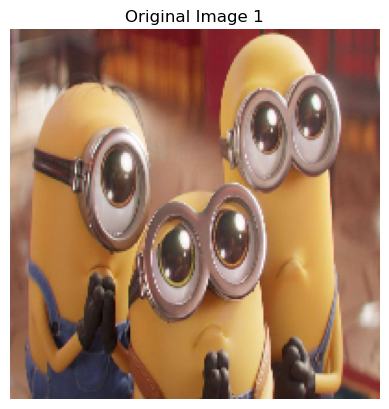

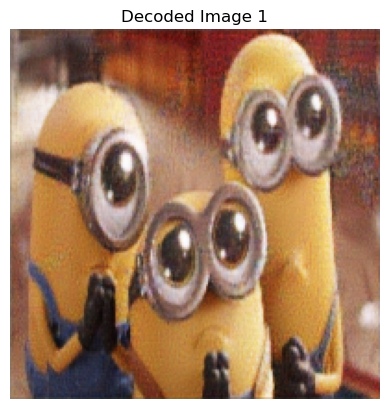

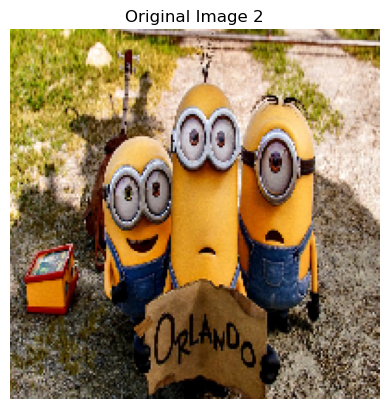

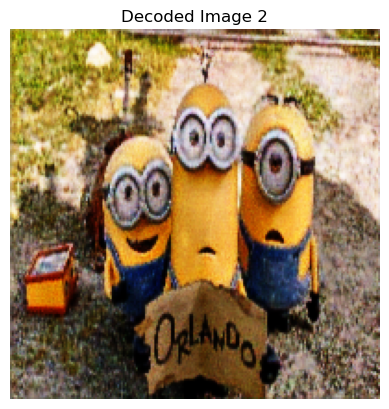

In [40]:
# Display original and decoded images
def show_plot(img, title):
    plt.imshow(img[0])
    plt.axis('off')
    plt.title(title)
    plt.show()

show_plot(image_1, "Original Image 1")
show_plot(decoded_img_1, "Decoded Image 1")

show_plot(image_2, "Original Image 2")
show_plot(decoded_img_2, "Decoded Image 2")

Epoch 1, Loss: 70320.34375
Epoch 2, Loss: 70272.8203125
Epoch 3, Loss: 70272.6015625
Epoch 4, Loss: 70373.9765625
Epoch 5, Loss: 70301.0390625
Epoch 6, Loss: 70254.1484375
Epoch 7, Loss: 70257.390625
Epoch 8, Loss: 70286.765625
Epoch 9, Loss: 70246.84375
Epoch 10, Loss: 70254.28125
Epoch 11, Loss: 70256.734375
Epoch 12, Loss: 70287.171875
Epoch 13, Loss: 70250.6484375
Epoch 14, Loss: 70251.578125
Epoch 15, Loss: 70219.8671875
Epoch 16, Loss: 70218.7109375
Epoch 17, Loss: 70259.640625
Epoch 18, Loss: 70201.4453125
Epoch 19, Loss: 70236.3828125
Epoch 20, Loss: 70277.8125
Epoch 21, Loss: 70208.1484375
Epoch 22, Loss: 70228.390625
Epoch 23, Loss: 70212.3671875
Epoch 24, Loss: 70184.1484375
Epoch 25, Loss: 70210.046875
Epoch 26, Loss: 70173.671875
Epoch 27, Loss: 70164.53125
Epoch 28, Loss: 70173.2109375
Epoch 29, Loss: 70192.46875
Epoch 30, Loss: 70158.3984375
Epoch 31, Loss: 70187.0078125
Epoch 32, Loss: 70226.421875
Epoch 33, Loss: 70205.7265625
Epoch 34, Loss: 70179.8046875
Epoch 35, Lo

Epoch 278, Loss: 69955.40625
Epoch 279, Loss: 69962.984375
Epoch 280, Loss: 69958.359375
Epoch 281, Loss: 69934.0234375
Epoch 282, Loss: 69945.3515625
Epoch 283, Loss: 70039.65625
Epoch 284, Loss: 69952.3125
Epoch 285, Loss: 69946.4375
Epoch 286, Loss: 69966.1015625
Epoch 287, Loss: 69968.2578125
Epoch 288, Loss: 69948.890625
Epoch 289, Loss: 70022.65625
Epoch 290, Loss: 69945.1640625
Epoch 291, Loss: 69970.5546875
Epoch 292, Loss: 69950.75
Epoch 293, Loss: 69981.6171875
Epoch 294, Loss: 69935.46875
Epoch 295, Loss: 69936.7890625
Epoch 296, Loss: 69937.3515625
Epoch 297, Loss: 69935.421875
Epoch 298, Loss: 69930.09375
Epoch 299, Loss: 69951.546875
Epoch 300, Loss: 69940.4453125
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
z_mean: [[3.3275442 8.857312 ]], z_log_var: [[-4.064732  -2.8211184]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
(1, 200, 200, 3)


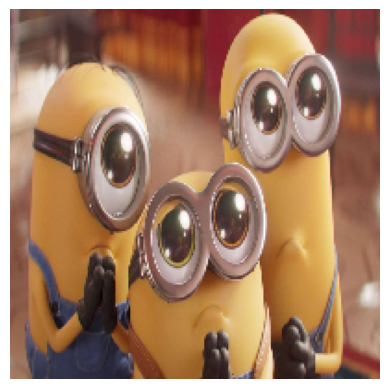

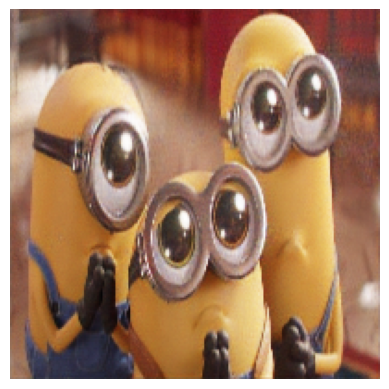

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
z_mean: [[16.997164   1.3639799]], z_log_var: [[-0.5473709 -2.7626438]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
(1, 200, 200, 3)


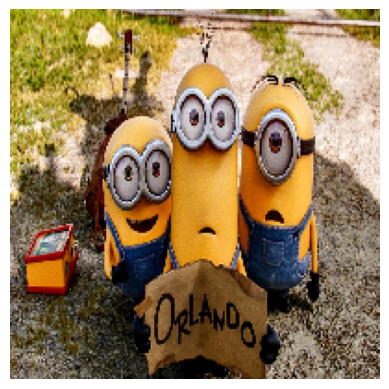

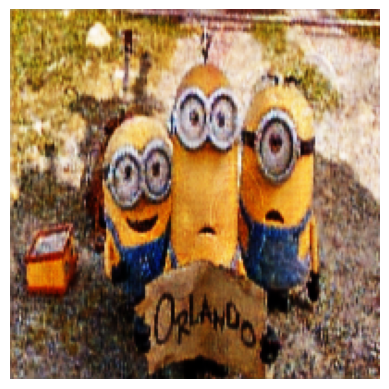

In [41]:
# Train the model
epochs = 300  # Increased epochs
for epoch in range(epochs):
    loss = train_step(image_1)
    print(f'Epoch {epoch + 1}, Loss: {loss.numpy()}')

# Sample the latent space
def sample_latent_space(encoder, img):
    z_mean, z_log_var, z = encoder.predict(img)
    print(f"z_mean: {z_mean}, z_log_var: {z_log_var}")
    return z_mean, z_log_var, z

z_mean, z_log_var, encoded_img_1 = sample_latent_space(encoder, image_1)

# Generate images
def generate_image(decoder, encoded_img):
    decoded_img = decoder.predict(encoded_img)
    return decoded_img

decoded_img_1 = generate_image(decoder, encoded_img_1)
print(decoded_img_1.shape)

# Display original and decoded images
def show_plot(img):
    plt.imshow(img[0])
    plt.axis('off')
    plt.show()

show_plot(image_1)
show_plot(decoded_img_1)

# New input data
z_mean, z_log_var, encoded_img_2 = sample_latent_space(encoder, image_2)
decoded_img_2 = generate_image(decoder, encoded_img_2)
print(decoded_img_2.shape)
show_plot(image_2)
show_plot(decoded_img_2)

# 4. New input data.

Rerun the generate copy code with the other picture, call it pic_2.

What output do you see? Explain why.

- tried 10 epoch first but the decoded images do not closely resemble the original images, it means the VAE is not learning to reconstruct the input images effectively
- So I tried 100 epoch generated better out put than 10 epoch but for 300 epoch the second picture generated did not perform well than 10 epoch
- WE can conculde that training for More Epochs, iterations can help the model to learn better but early stopping in needed before the loss increase.